In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sklearn.datasets
import itertools
import random
%matplotlib inline

In [8]:

class SNN(nn.Module):
    def __init__(self, n_class=2, hidden_dim=32, noise_dim=32, feature_dim=32,device='cuda',
                 n_prototype=32, separate=False):
        super(SNN, self).__init__()

        self.n_class = n_class
        self.hidden_dim = hidden_dim
        self.noise_dim = noise_dim
        self.feature_dim = feature_dim
        self.n_prototype = n_prototype
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_c1 = nn.Linear(hidden_dim, self.feature_dim)
        self.fc3_c2 = nn.Linear(hidden_dim, self.feature_dim)
        
        self.class_embeddings = torch.eye(self.n_class).to(device)
        
        self.prototype_generator = nn.Sequential(nn.Linear(self.n_class+self.noise_dim, self.hidden_dim), 
                                                 nn.ReLU(),
                                                 nn.Linear(self.hidden_dim, self.feature_dim))
        self.device=device

    def forward(self, x, method='kde', separate=False):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x1 = self.fc3_c1(x).unsqueeze(1)
        x2 = self.fc3_c2(x).unsqueeze(1)
        x = torch.cat([x1, x2], dim=1)
        return x
    
    def get_prototype(self, n_prototype=32):
        prototype = torch.cat([torch.randn(self.class_embeddings.shape[0]*n_prototype, self.noise_dim).to(self.device), 
                               self.class_embeddings.repeat(1,n_prototype).view(-1, self.n_class)], dim=1)
        prototype = self.prototype_generator(prototype)
        return prototype.view(self.n_class,n_prototype,self.feature_dim)


    def classify(self, x, prototype=None, sampling=True, n_samples=32, sigma=1.0, separate=False, n_ensemble=1):
        if prototype is None:
            prototype = self.get_prototype()
            
        logit = kde(x, prototype, sigma=sigma, separate=separate, n_ensemble=n_ensemble)
        
        return logit
    


In [9]:
def kde(sample, base, sigma=1.0, separate=False, n_ensemble=1):

    if separate:
        logit_0 = kde(sample.clone()[:,0,:], base[:1], sigma=1.0, separate=False)
        logit_1 = kde(sample.clone()[:,1,:], base[1:], sigma=1.0, separate=False)
        return torch.cat([logit_0, logit_1], dim=1)
    else:
        d = sample[:,None,None,:]-base[None,:,:,:]
        n_samples, n_class, n_prototype, prototype_dim = d.shape
        if n_ensemble > 1:
            d = d.reshape([n_samples, n_class, n_ensemble, n_prototype // n_ensemble, prototype_dim])
        d = d**2
        d = d.sum(dim=-1)
        kernel = -d/sigma

        return kernel.mean(dim=-1)

def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]


    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    gradient_penalty = ((grad_norm - 1.0) ** 2).mean()


    return gradient_penalty

In [29]:
seed = 1
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
# random.seed(seed)
# torch.backends.cudnn.deterministic = True

batch_size = 64
gaussian_feature = False
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

In [30]:
reg_term_weight = 1.0
grad_weights=1.0
separate=True
gradient_loss_weights = 1.0
k=5
device='cuda'

hidden_dim = 32
feature_dim= 32
n_class=2
noise_dim=32
n_prototype=32

for it in range(1):
    model = SNN(hidden_dim=hidden_dim,feature_dim=feature_dim, separate=separate).to(device)
    loss_func = F.binary_cross_entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    for epoch in range(60):

        for batch_idx, (data, target) in enumerate(dl_train):
            target_true=torch.where(target==1)[1]
            target_false=torch.where(target==0)[1]
            data.requires_grad_(True)

            optimizer.zero_grad()

            feature = model(data.to('cuda'), separate=separate)
            prototype = model.get_prototype()
            logit = model.classify(feature, prototype, n_samples=n_prototype, 
                                   separate=separate)
            exp_logit = torch.exp(logit)
        
            entropy_proto = torch.cdist(prototype, prototype).sort(dim=-1)[0][:,:,1:k+1].mean([-1,-2])
            entropy_feature = torch.zeros(n_class,requires_grad=False).to(device)
            for c in range(n_class):
                feature_class = feature[torch.where(target_true == c)[0]]
                if feature_class.shape[0]>1:
                    entropy_feature[c] = torch.cdist(feature[torch.where(target_true == c)[0]][:,c].contiguous(),
                                                     feature[torch.where(target_true == c)[0]][:,c].contiguous()).sort(
                        dim=-1)[0][:, 1:k + 1].mean()
                else:
                    entropy_feature[c] = 0.01
                    
            reg_term_proto = torch.relu(entropy_feature-entropy_proto).mean()

            grad_loss = calc_gradient_penalty(data, exp_logit)
            ce_loss = loss_func(exp_logit, F.one_hot(target_true, num_classes=2).float().to(device))
            
            loss = ce_loss + grad_weights*grad_loss + reg_term_weight*(reg_term_proto)

            loss.backward()
            optimizer.step()



            if batch_idx % 100 == 0:
                print(epoch, batch_idx, 
                      ce_loss.detach().cpu().numpy(),
                      reg_term_proto.detach().cpu().numpy())
        acc = []
        conf = []
        for (data, target) in dl_test:
            target_true=torch.where(target==1)[1]
            test_feature = model(data.to(device), separate=separate)
            prototype = model.get_prototype()
            test_feature_logit = model.classify(test_feature, prototype, n_samples=n_prototype, separate=separate)
            test_pred = F.softmax(test_feature_logit, dim=1)
            acc.append((test_pred.argmax(-1)==target_true.to(device)).float().mean().detach().cpu().numpy())  
            conf.append(test_pred.max(-1)[0].float().mean().detach().cpu().numpy())
        print('Testing Acc. %f' % np.mean(acc))
        print('Testing Conf. %f\n' % np.mean(conf))

0 0 1.3773291 0.0
Testing Acc. 0.640000
Testing Conf. 0.542283

1 0 0.8625089 0.0
Testing Acc. 0.745000
Testing Conf. 0.620221

2 0 0.67519367 0.0
Testing Acc. 0.795000
Testing Conf. 0.683805

3 0 0.57870513 0.0
Testing Acc. 0.845000
Testing Conf. 0.733030

4 0 0.47841084 0.0
Testing Acc. 0.865000
Testing Conf. 0.751428

5 0 0.43731582 0.0
Testing Acc. 0.885000
Testing Conf. 0.780275

6 0 0.3837793 0.0
Testing Acc. 0.890000
Testing Conf. 0.792541

7 0 0.42220402 0.0
Testing Acc. 0.900000
Testing Conf. 0.805609

8 0 0.32026672 0.0
Testing Acc. 0.910000
Testing Conf. 0.818558

9 0 0.3696393 0.0
Testing Acc. 0.920000
Testing Conf. 0.826237

10 0 0.3254365 0.0
Testing Acc. 0.925000
Testing Conf. 0.830200

11 0 0.29976028 0.0
Testing Acc. 0.925000
Testing Conf. 0.836899

12 0 0.29861087 0.0
Testing Acc. 0.930000
Testing Conf. 0.841064

13 0 0.2687956 0.0
Testing Acc. 0.940000
Testing Conf. 0.844423

14 0 0.214434 0.0
Testing Acc. 0.960000
Testing Conf. 0.854095

15 0 0.18483415 0.0
Testing 

In [32]:
target_true

tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0])

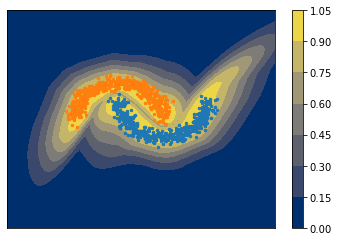

In [31]:
domain = 3
x_lin = np.linspace(-domain-0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=0.1)
mask = y_vis.astype(bool)

with torch.no_grad():
    feature = model(torch.from_numpy(X_grid).float().to('cuda'), separate=separate)
    prototype = model.get_prototype()
    logit = model.classify(feature, prototype, separate=separate)
    exp_logit = torch.exp(logit)
    exp_confidence = exp_logit.max(-1)[0].float().detach().cpu().numpy()


z = exp_confidence.reshape(xx.shape)

plt.figure(figsize=(6,4))
plt.contourf(x_lin, y_lin, z, cmap='cividis')
plt.colorbar()
plt.scatter(X_vis[mask,0], X_vis[mask,1], s=6)
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], s=6)
plt.xlim([-2.5, 3.5])
plt.tick_params(
    axis='x',         
    which='both',    
    bottom=False,     
    top=False,        
    labelbottom=False)
plt.tick_params(
    axis='y',         
    which='both',     
    right=False,      
    left=False,       
    labelleft=False)